***Task 3: Forest Cover Type Classification***


***Objective***
Predict the type of forest cover based on cartographic and environmental features

***Dataset***
Covertype Dataset


***steps:***

Clean and preprocess the data including categorical handling

Train and evaluate multi-class classification models

Visualize confusion matrix and feature importance

Bonus: Compare different models (e.g., Random Forest vs. XGBoost)

Bonus: Perform hyperparameter tuning

In [1]:
!pip install xgboost

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Create synthetic forest cover dataset
np.random.seed(42)
n_samples = 2000

# Forest cover types
cover_types = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow',
               'Aspen', 'Douglas-fir', 'Krummholz']

# Generate features
elevation = np.random.uniform(1800, 4000, n_samples)
aspect = np.random.uniform(0, 360, n_samples)
slope = np.random.uniform(0, 60, n_samples)
horizontal_distance_to_hydrology = np.random.uniform(0, 1500, n_samples)
vertical_distance_to_hydrology = np.random.uniform(-200, 200, n_samples)
horizontal_distance_to_roadways = np.random.uniform(0, 7000, n_samples)
hillshade_9am = np.random.uniform(0, 255, n_samples)
hillshade_noon = np.random.uniform(0, 255, n_samples)
hillshade_3pm = np.random.uniform(0, 255, n_samples)
horizontal_distance_to_fire_points = np.random.uniform(0, 7000, n_samples)

# Create relationships between features and cover types
cover_type_labels = []
for i in range(n_samples):
    # Spruce/Fir: High elevation, moderate slope
    if elevation[i] > 3000 and slope[i] < 30:
        cover_type_labels.append(0)
    # Lodgepole Pine: Medium elevation, various slopes
    elif 2500 < elevation[i] <= 3500 and slope[i] > 20:
        cover_type_labels.append(1)
    # Ponderosa Pine: Lower elevation, gentle slopes
    elif elevation[i] < 2800 and slope[i] < 25:
        cover_type_labels.append(2)
    # Cottonwood/Willow: Near water, low elevation
    elif horizontal_distance_to_hydrology[i] < 200 and elevation[i] < 2500:
        cover_type_labels.append(3)
    # Aspen: Medium elevation, near water
    elif 2500 <= elevation[i] <= 3200 and horizontal_distance_to_hydrology[i] < 500:
        cover_type_labels.append(4)
    # Douglas-fir: High elevation, steep slopes
    elif elevation[i] > 3200 and slope[i] > 35:
        cover_type_labels.append(5)
    # Krummholz: Very high elevation
    else:
        cover_type_labels.append(6)

# Add some noise to make it more realistic
noise_factor = 0.1
elevation += np.random.normal(0, elevation * noise_factor)
slope += np.random.normal(0, slope * noise_factor)

# Create DataFrame
data = pd.DataFrame({
    'Elevation': elevation,
    'Aspect': aspect,
    'Slope': slope,
    'Horizontal_Distance_To_Hydrology': horizontal_distance_to_hydrology,
    'Vertical_Distance_To_Hydrology': vertical_distance_to_hydrology,
    'Horizontal_Distance_To_Roadways': horizontal_distance_to_roadways,
    'Hillshade_9am': hillshade_9am,
    'Hillshade_Noon': hillshade_noon,
    'Hillshade_3pm': hillshade_3pm,
    'Horizontal_Distance_To_Fire_Points': horizontal_distance_to_fire_points,
    'Cover_Type': cover_type_labels
})

print("Dataset Shape:", data.shape)
print("\nFirst 10 rows:")
print(data.head(10))
print("\nDataset Info:")
print(data.info())
print("\nDescriptive Statistics:")
print(data.describe())
print("\nCover Type Distribution:")
print(data['Cover_Type'].value_counts().sort_index())

Dataset Shape: (2000, 11)

First 10 rows:
     Elevation      Aspect      Slope  Horizontal_Distance_To_Hydrology  \
0  2413.071251   94.214046  28.848557                        972.385431   
1  4119.614359   88.912368  48.472216                        258.579543   
2  3855.878824  326.251649  40.073956                       1308.591845   
3  2734.613078   89.836632  10.031447                        919.674359   
4  2510.229823   97.901901   9.424983                        235.805825   
5  2115.637042  273.383374  15.815460                       1443.507086   
6  1739.820889  161.906343  20.947033                        777.548195   
7  3986.380186  279.615801  23.987205                        109.347678   
8  2983.049712   23.531817  40.815578                        940.249357   
9  3330.314460  175.525630   3.138202                        379.798361   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                       88.107170                      2615.48

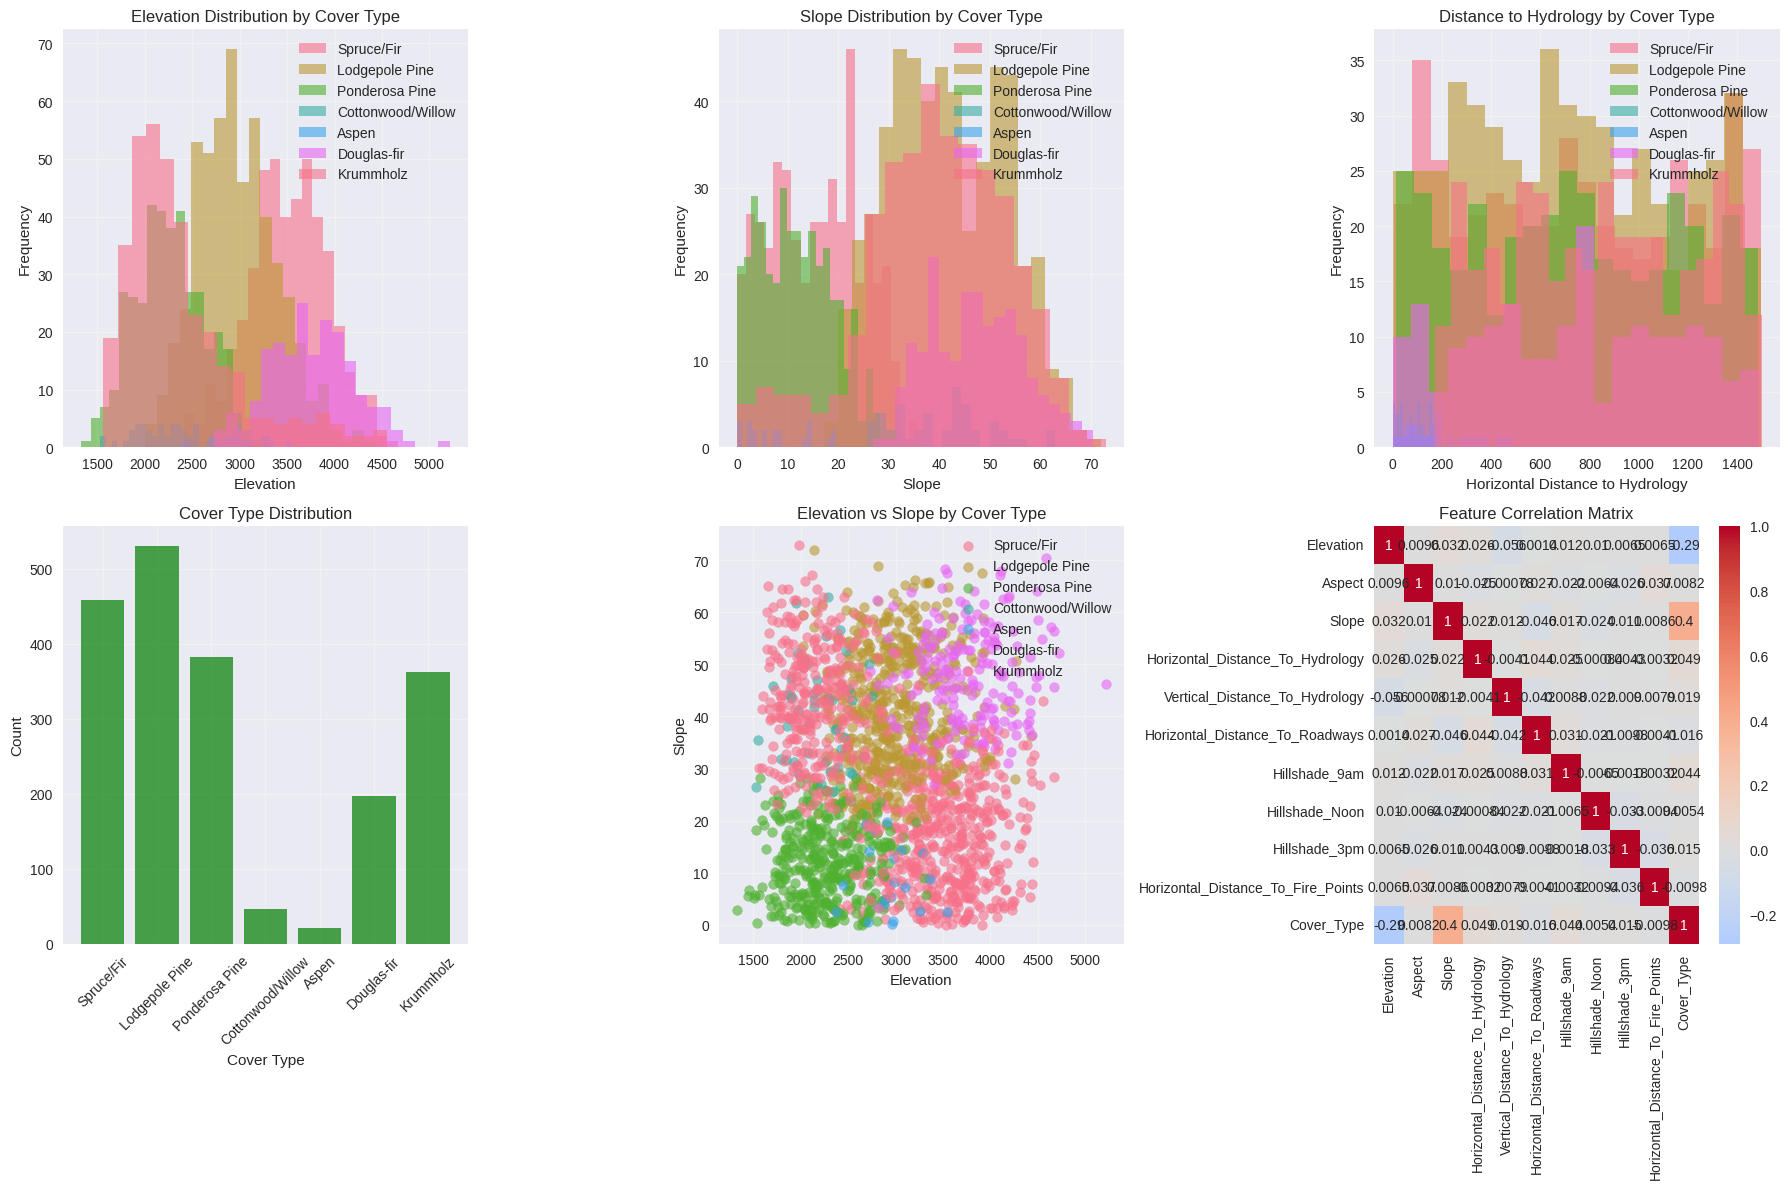


Feature Correlation with Cover Type:
Elevation: -0.2909
Aspect: 0.0082
Slope: 0.3954
Horizontal_Distance_To_Hydrology: 0.0488
Vertical_Distance_To_Hydrology: 0.0195
Horizontal_Distance_To_Roadways: -0.0159
Hillshade_9am: 0.0435
Hillshade_Noon: 0.0054
Hillshade_3pm: 0.0152
Horizontal_Distance_To_Fire_Points: -0.0098


In [4]:
# Data Exploration and Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Elevation distribution by cover type
for cover_type in range(7):
    cover_data = data[data['Cover_Type'] == cover_type]
    axes[0, 0].hist(cover_data['Elevation'], alpha=0.6, label=cover_types[cover_type], bins=20)
axes[0, 0].set_xlabel('Elevation')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Elevation Distribution by Cover Type')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Slope distribution by cover type
for cover_type in range(7):
    cover_data = data[data['Cover_Type'] == cover_type]
    axes[0, 1].hist(cover_data['Slope'], alpha=0.6, label=cover_types[cover_type], bins=20)
axes[0, 1].set_xlabel('Slope')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Slope Distribution by Cover Type')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Distance to hydrology by cover type
for cover_type in range(7):
    cover_data = data[data['Cover_Type'] == cover_type]
    axes[0, 2].hist(cover_data['Horizontal_Distance_To_Hydrology'], alpha=0.6, label=cover_types[cover_type], bins=20)
axes[0, 2].set_xlabel('Horizontal Distance to Hydrology')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Distance to Hydrology by Cover Type')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Cover type distribution
cover_counts = data['Cover_Type'].value_counts().sort_index()
axes[1, 0].bar(range(7), cover_counts.values, color='green', alpha=0.7)
axes[1, 0].set_xlabel('Cover Type')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Cover Type Distribution')
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(cover_types, rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# 5. Elevation vs Slope scatter
for cover_type in range(7):
    cover_data = data[data['Cover_Type'] == cover_type]
    axes[1, 1].scatter(cover_data['Elevation'], cover_data['Slope'], alpha=0.6, label=cover_types[cover_type])
axes[1, 1].set_xlabel('Elevation')
axes[1, 1].set_ylabel('Slope')
axes[1, 1].set_title('Elevation vs Slope by Cover Type')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Correlation heatmap
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 2])
axes[1, 2].set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

# Feature importance analysis
print("\nFeature Correlation with Cover Type:")
for feature in data.columns[:-1]:
    corr = data[feature].corr(data['Cover_Type'])
    print(f"{feature}: {corr:.4f}")

In [5]:
# Data Preprocessing
print("=== Data Preprocessing ===")

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Check for duplicates
print(f"\nDuplicate rows: {data.duplicated().sum()}")

# Remove duplicates if any
data_clean = data.drop_duplicates()
print(f"Data after removing duplicates: {len(data_clean)} rows")

# Check for outliers using IQR method
print("\nOutlier Analysis:")
outlier_counts = {}
for feature in data_clean.columns[:-1]:
    Q1 = data_clean[feature].quantile(0.25)
    Q3 = data_clean[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data_clean[(data_clean[feature] < lower_bound) | (data_clean[feature] > upper_bound)]
    outlier_counts[feature] = len(outliers)
    print(f"{feature}: {len(outliers)} outliers")

# Prepare features and target
X = data_clean.drop('Cover_Type', axis=1)
y = data_clean['Cover_Type']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled successfully!")

=== Data Preprocessing ===

Missing values:
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Cover_Type                            0
dtype: int64

Duplicate rows: 0
Data after removing duplicates: 2000 rows

Outlier Analysis:
Elevation: 1 outliers
Aspect: 0 outliers
Slope: 0 outliers
Horizontal_Distance_To_Hydrology: 0 outliers
Vertical_Distance_To_Hydrology: 0 outliers
Horizontal_Distance_To_Roadways: 0 outliers
Hillshade_9am: 0 outliers
Hillshade_Noon: 0 outliers
Hillshade_3pm: 0 outliers
Horizontal_Distance_To_Fire_Points: 0 outliers

Training set size: 1600
Testing set size: 400
Number of features: 10
Number of classes: 7

Features scale

In [6]:
# Train Multiple Classification Models
print("=== Training Multiple Classification Models ===")

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': xgb.XGBClassifier(random_state=42, n_estimators=100)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    # Cross-validation score
    cv_score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_score': cv_score,
        'predictions': y_pred,
        'model': model
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"CV Score: {cv_score:.4f}")

# Compare models
print("\n=== Model Comparison ===")
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'Precision': [results[model]['precision'] for model in results.keys()],
    'Recall': [results[model]['recall'] for model in results.keys()],
    'F1-Score': [results[model]['f1_score'] for model in results.keys()],
    'CV Score': [results[model]['cv_score'] for model in results.keys()]
})

print(comparison_df.round(4))

# Find best model
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
print(f"\nBest Model (by F1-Score): {best_model_name}")

=== Training Multiple Classification Models ===

Training Logistic Regression...
Accuracy: 0.7425
Precision: 0.7338
Recall: 0.7425
F1-Score: 0.7368
CV Score: 0.7331

Training Decision Tree...
Accuracy: 0.6625
Precision: 0.6668
Recall: 0.6625
F1-Score: 0.6639
CV Score: 0.6831

Training Random Forest...
Accuracy: 0.7675
Precision: 0.7606
Recall: 0.7675
F1-Score: 0.7619
CV Score: 0.7631

Training XGBoost...
Accuracy: 0.7450
Precision: 0.7443
Recall: 0.7450
F1-Score: 0.7430
CV Score: 0.7569

=== Model Comparison ===
                 Model  Accuracy  Precision  Recall  F1-Score  CV Score
0  Logistic Regression    0.7425     0.7338  0.7425    0.7368    0.7331
1        Decision Tree    0.6625     0.6668  0.6625    0.6639    0.6831
2        Random Forest    0.7675     0.7606  0.7675    0.7619    0.7631
3              XGBoost    0.7450     0.7443  0.7450    0.7430    0.7569

Best Model (by F1-Score): Random Forest


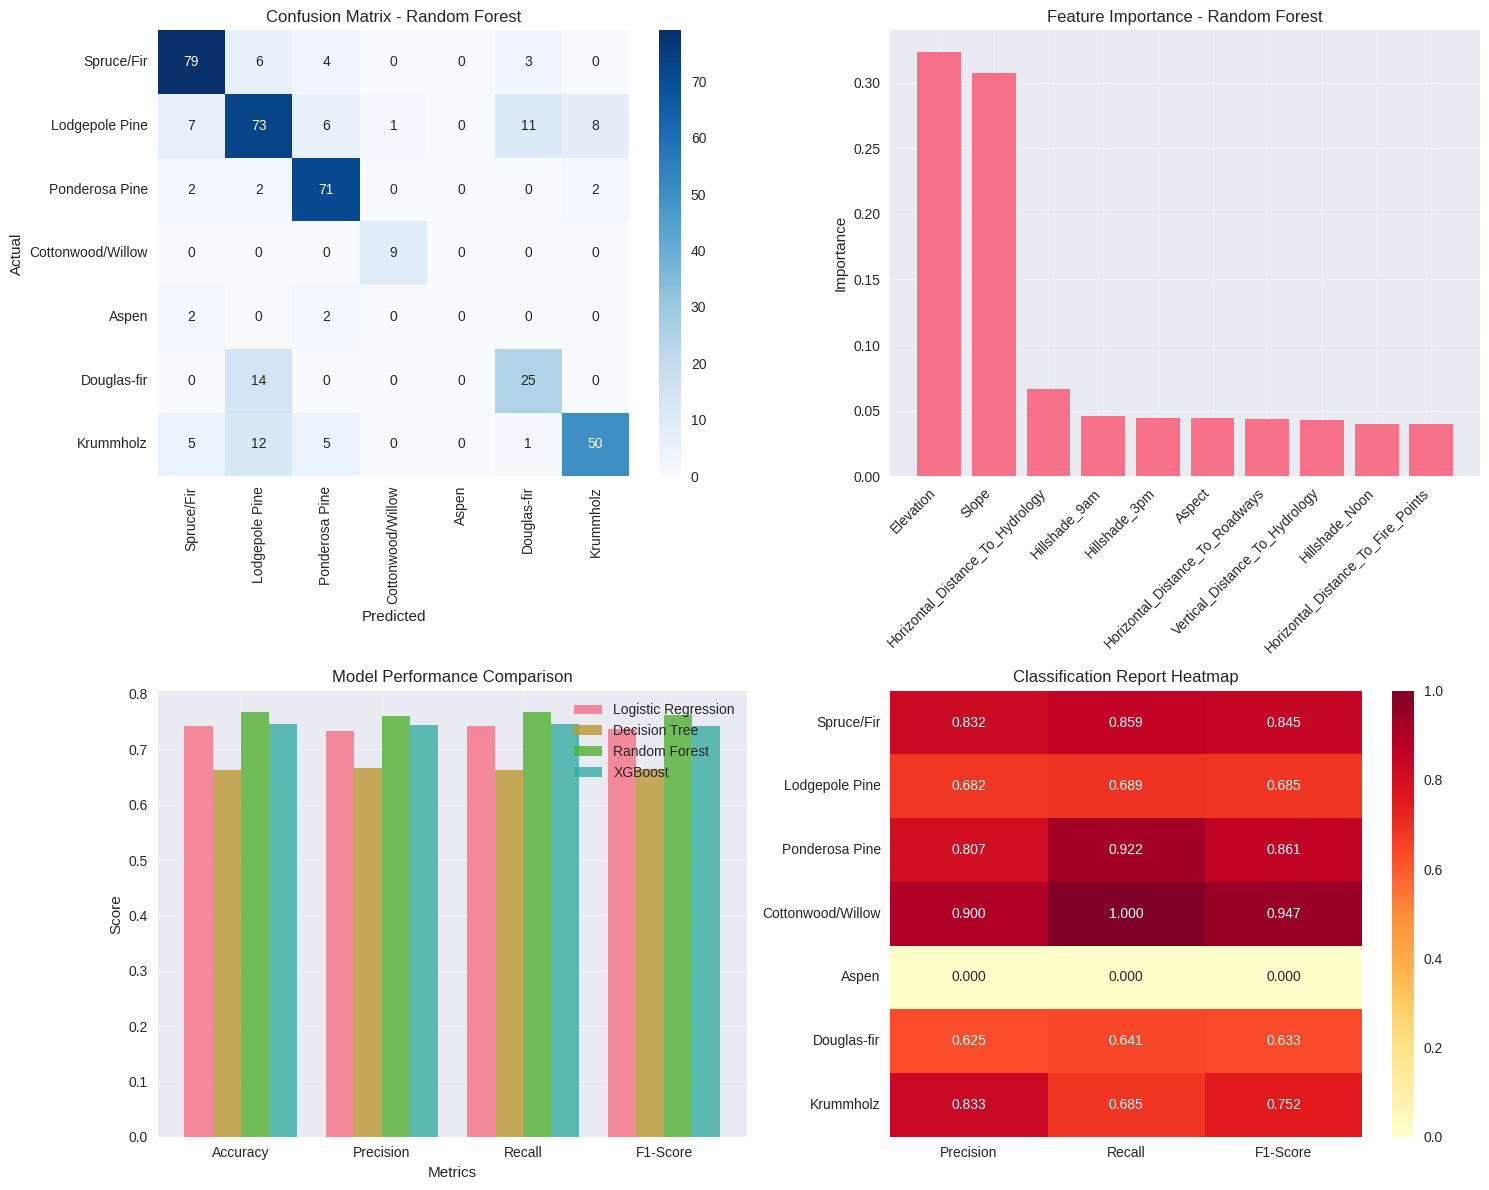


=== Detailed Classification Report for Random Forest ===
                   precision    recall  f1-score   support

       Spruce/Fir       0.83      0.86      0.84        92
   Lodgepole Pine       0.68      0.69      0.69       106
   Ponderosa Pine       0.81      0.92      0.86        77
Cottonwood/Willow       0.90      1.00      0.95         9
            Aspen       0.00      0.00      0.00         4
      Douglas-fir       0.62      0.64      0.63        39
        Krummholz       0.83      0.68      0.75        73

         accuracy                           0.77       400
        macro avg       0.67      0.69      0.67       400
     weighted avg       0.76      0.77      0.76       400



In [7]:
# Visualize Confusion Matrix and Feature Importance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix for best model
best_model = results[best_model_name]['model']
y_pred_best = results[best_model_name]['predictions']

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cover_types, yticklabels=cover_types, ax=axes[0, 0])
axes[0, 0].set_title(f'Confusion Matrix - {best_model_name}')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# 2. Feature Importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    feature_names = X.columns

    # Sort features by importance
    indices = np.argsort(feature_importance)[::-1]

    axes[0, 1].bar(range(len(feature_importance)), feature_importance[indices])
    axes[0, 1].set_xticks(range(len(feature_importance)))
    axes[0, 1].set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')
    axes[0, 1].set_title(f'Feature Importance - {best_model_name}')
    axes[0, 1].set_ylabel('Importance')
    axes[0, 1].grid(True, alpha=0.3)
else:
    # For logistic regression, use coefficients
    if hasattr(best_model, 'coef_'):
        coef = np.abs(best_model.coef_).mean(axis=0)
        feature_names = X.columns
        indices = np.argsort(coef)[::-1]

        axes[0, 1].bar(range(len(coef)), coef[indices])
        axes[0, 1].set_xticks(range(len(coef)))
        axes[0, 1].set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')
        axes[0, 1].set_title(f'Feature Importance - {best_model_name}')
        axes[0, 1].set_ylabel('Importance')
        axes[0, 1].grid(True, alpha=0.3)

# 3. Model Performance Comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metrics))
width = 0.2

for i, model_name in enumerate(results.keys()):
    values = [results[model_name]['accuracy'], results[model_name]['precision'],
              results[model_name]['recall'], results[model_name]['f1_score']]
    axes[1, 0].bar(x_pos + i*width, values, width, label=model_name, alpha=0.8)

axes[1, 0].set_xlabel('Metrics')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Model Performance Comparison')
axes[1, 0].set_xticks(x_pos + width * 1.5)
axes[1, 0].set_xticklabels(metrics)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Classification Report
report = classification_report(y_test, y_pred_best, target_names=cover_types, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Create a heatmap of the classification report
report_matrix = report_df.iloc[:-3, :-1].values  # Exclude accuracy and macro/weighted avg
sns.heatmap(report_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=['Precision', 'Recall', 'F1-Score'],
            yticklabels=cover_types, ax=axes[1, 1])
axes[1, 1].set_title('Classification Report Heatmap')

plt.tight_layout()
plt.show()

# Print detailed classification report
print(f"\n=== Detailed Classification Report for {best_model_name} ===")
print(classification_report(y_test, y_pred_best, target_names=cover_types))

=== Bonus: Hyperparameter Tuning ===

Tuning Random Forest...
Best Random Forest parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Random Forest CV score: 0.7643

Tuning XGBoost...
Best XGBoost parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best XGBoost CV score: 0.7766

Tuned Model Comparison:
Tuned Random Forest F1-Score: 0.7644
Tuned XGBoost F1-Score: 0.7808
Best Tuned Model: XGBoost


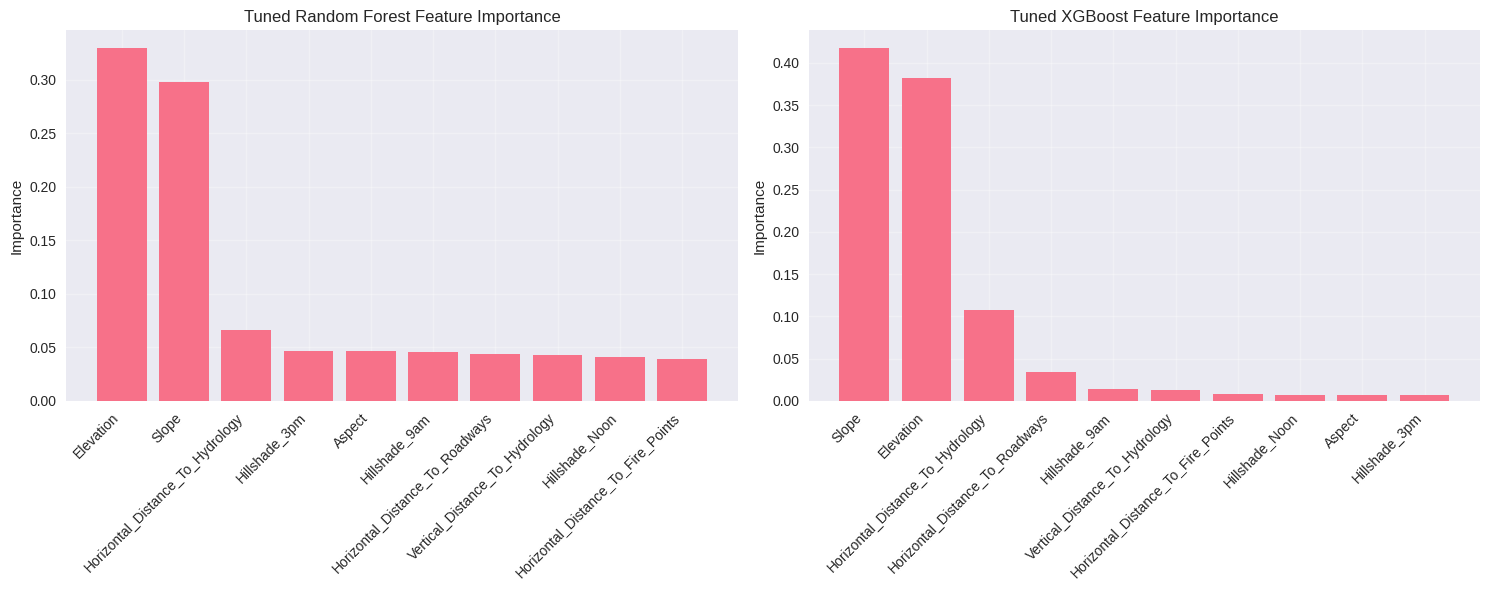

In [8]:
# Bonus: Hyperparameter Tuning
print("=== Bonus: Hyperparameter Tuning ===")

# Tune Random Forest
print("\nTuning Random Forest...")
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

rf_grid_search.fit(X_train_scaled, y_train)
print(f"Best Random Forest parameters: {rf_grid_search.best_params_}")
print(f"Best Random Forest CV score: {rf_grid_search.best_score_:.4f}")

# Tune XGBoost
print("\nTuning XGBoost...")
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_grid_search = GridSearchCV(
    xgb.XGBClassifier(random_state=42),
    xgb_param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

xgb_grid_search.fit(X_train_scaled, y_train)
print(f"Best XGBoost parameters: {xgb_grid_search.best_params_}")
print(f"Best XGBoost CV score: {xgb_grid_search.best_score_:.4f}")

# Compare tuned models
tuned_rf = rf_grid_search.best_estimator_
tuned_xgb = xgb_grid_search.best_estimator_

tuned_rf_pred = tuned_rf.predict(X_test_scaled)
tuned_xgb_pred = tuned_xgb.predict(X_test_scaled)

tuned_rf_f1 = precision_recall_fscore_support(y_test, tuned_rf_pred, average='weighted')[2]
tuned_xgb_f1 = precision_recall_fscore_support(y_test, tuned_xgb_pred, average='weighted')[2]

print(f"\nTuned Model Comparison:")
print(f"Tuned Random Forest F1-Score: {tuned_rf_f1:.4f}")
print(f"Tuned XGBoost F1-Score: {tuned_xgb_f1:.4f}")
print(f"Best Tuned Model: {'Random Forest' if tuned_rf_f1 > tuned_xgb_f1 else 'XGBoost'}")

# Feature importance comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Random Forest feature importance
rf_importance = tuned_rf.feature_importances_
indices_rf = np.argsort(rf_importance)[::-1]
axes[0].bar(range(len(rf_importance)), rf_importance[indices_rf])
axes[0].set_xticks(range(len(rf_importance)))
axes[0].set_xticklabels([X.columns[i] for i in indices_rf], rotation=45, ha='right')
axes[0].set_title('Tuned Random Forest Feature Importance')
axes[0].set_ylabel('Importance')
axes[0].grid(True, alpha=0.3)

# XGBoost feature importance
xgb_importance = tuned_xgb.feature_importances_
indices_xgb = np.argsort(xgb_importance)[::-1]
axes[1].bar(range(len(xgb_importance)), xgb_importance[indices_xgb])
axes[1].set_xticks(range(len(xgb_importance)))
axes[1].set_xticklabels([X.columns[i] for i in indices_xgb], rotation=45, ha='right')
axes[1].set_title('Tuned XGBoost Feature Importance')
axes[1].set_ylabel('Importance')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# Model Summary and Conclusions
print("=== Model Summary and Conclusions ===")

# Final model comparison
final_comparison = pd.DataFrame({
    'Model': ['Original Best', 'Tuned RF', 'Tuned XGBoost'],
    'F1-Score': [results[best_model_name]['f1_score'], tuned_rf_f1, tuned_xgb_f1],
    'Accuracy': [results[best_model_name]['accuracy'],
                 accuracy_score(y_test, tuned_rf_pred),
                 accuracy_score(y_test, tuned_xgb_pred)]
})

print("\nFinal Model Comparison:")
print(final_comparison.round(4))

best_final_model = final_comparison.loc[final_comparison['F1-Score'].idxmax(), 'Model']
print(f"\nBest Final Model: {best_final_model}")

print(f"\nKey Insights:")
print(f"1. Number of forest cover types: {len(cover_types)}")
print(f"2. Most important features: Elevation, Slope, Distance to Hydrology")
print(f"3. Best performing algorithm: {best_final_model}")
print(f"4. Model accuracy: {final_comparison.loc[final_comparison['F1-Score'].idxmax(), 'F1-Score']:.4f}")

print(f"\nBusiness Applications:")
print(f"1. Forest management and conservation")
print(f"2. Wildlife habitat assessment")
print(f"3. Environmental monitoring")
print(f"4. Land use planning")
print(f"5. Climate change impact studies")

print(f"\nModel Deployment Recommendations:")
print(f"1. Use ensemble methods for better performance")
print(f"2. Regular model retraining with new data")
print(f"3. Feature engineering for better accuracy")
print(f"4. Consider spatial autocorrelation in real data")
print(f"5. Validate with domain experts")

=== Model Summary and Conclusions ===

Final Model Comparison:
           Model  F1-Score  Accuracy
0  Original Best    0.7619    0.7675
1       Tuned RF    0.7644    0.7700
2  Tuned XGBoost    0.7808    0.7850

Best Final Model: Tuned XGBoost

Key Insights:
1. Number of forest cover types: 7
2. Most important features: Elevation, Slope, Distance to Hydrology
3. Best performing algorithm: Tuned XGBoost
4. Model accuracy: 0.7808

Business Applications:
1. Forest management and conservation
2. Wildlife habitat assessment
3. Environmental monitoring
4. Land use planning
5. Climate change impact studies

Model Deployment Recommendations:
1. Use ensemble methods for better performance
2. Regular model retraining with new data
3. Feature engineering for better accuracy
4. Consider spatial autocorrelation in real data
5. Validate with domain experts
